![lop](../../images/logo_diive1_128px.png)

<span style='font-size:32px; display:block;'>
<b>
    Format meteo data for EddyPro flux processing
</b>
</span>

---
**Notebook version**: `1` (24 Feb 2025)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

# **Background**

- Formats meteo data to be used in EddyPro flux processing

More info:
- [EddyPro help: Supported biomet file formats](https://www.licor.com/support/EddyPro/topics/biomet-data-format.html)

</br>

# **Settings**

## Variables

In [1]:
# Name of the variables in the original data file
SW_IN = 'SW_IN_T1_1_1'
RH = 'RH_T1_2_1'
PPFD_IN = 'PPFD_IN_T1_2_1'
LW_IN = 'LW_IN_T1_1_1'
TA = 'TA_T1_2_1'
# PA = None  # Not available for this site

# Rename original variables for EddyPro, and add units
rename_dict = {
    TA: ('Ta_1_1_1', 'C'),
    SW_IN: ('Rg_1_1_1', 'W+1m-2'),
    RH: ('RH_1_1_1', '%'),
    LW_IN: ('Lwin_1_1_1', 'W+1m-2'),
    # PA: ('Pa_1_1_1', 'kPa),
    PPFD_IN: ('PPFD_1_1_1', 'umol+1m-2s-1'),
}

## Database settings (used for example data)

In [2]:
# Settings for database download
SITE = 'ch-fru'  # Site name
START = '2024-01-01 00:01:00'  # Download data starting with this date
STOP = '2025-01-01 00:01:00'  # Download data before this date (the stop date itself is not included)
MEASUREMENTS = ['TA', 'RH', 'SW', 'PPFD', 'LW']
FIELDS = [TA, RH, SW_IN, LW_IN, PPFD_IN]  # No PA in this example
TIMEZONE_OFFSET_TO_UTC_HOURS = 1  # Timezone, e.g. "1" is translated to timezone "UTC+01:00" (CET, winter time)
data_version = "meteoscreening_diive"
DIRCONF = r'F:\Sync\luhk_work\20 - CODING\22 - POET\configs'

</br>

# **Imports**

In [3]:
import importlib.metadata
import warnings
from datetime import datetime

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from dbc_influxdb import dbcInflux

from diive.core.plotting.heatmap_datetime import HeatmapDateTime  # For plotting heatmaps
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.pkgs.formats.meteo import FormatMeteoForEddyProFluxProcessing  # Class to format output files for upload

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.85.6


</br>

# **Docstring**

In [4]:
# help(FormatMeteoForEddyProProcessing)

</br>

# **Load example data**
- This example uses data from a database.

In [5]:
dbc = dbcInflux(dirconf=DIRCONF)
df, _, _ = \
    dbc.download(bucket=f'{SITE}_processed',
                 measurements=MEASUREMENTS,
                 fields=FIELDS,
                 start=START,
                 stop=STOP,
                 timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
                 data_version='meteoscreening_diive')

Reading configuration files was successful.
Connection to database works.

DOWNLOADING
    from bucket ch-fru_processed
    variables ['TA_T1_2_1', 'RH_T1_2_1', 'SW_IN_T1_1_1', 'LW_IN_T1_1_1', 'PPFD_IN_T1_2_1']
    from measurements ['TA', 'RH', 'SW', 'PPFD', 'LW']
    from data version meteoscreening_diive
    between 2024-01-01 00:01:00 and 2025-01-01 00:01:00
    with timezone offset to UTC of 1
Used querystring: from(bucket: "ch-fru_processed") |> range(start: 2024-01-01T00:01:00+01:00, stop: 2025-01-01T00:01:00+01:00) |> filter(fn: (r) => r["_measurement"] == "TA" or r["_measurement"] == "RH" or r["_measurement"] == "SW" or r["_measurement"] == "PPFD" or r["_measurement"] == "LW") |> filter(fn: (r) => r["data_version"] == "meteoscreening_diive") |> filter(fn: (r) => r["_field"] == "TA_T1_2_1" or r["_field"] == "RH_T1_2_1" or r["_field"] == "SW_IN_T1_1_1" or r["_field"] == "LW_IN_T1_1_1" or r["_field"] == "PPFD_IN_T1_2_1") |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColu

The dataframe with original data looks like this:

In [6]:
df

,LW_IN_T1_1_1,PPFD_IN_T1_2_1,RH_T1_2_1,SW_IN_T1_1_1,TA_T1_2_1
TIMESTAMP_END,,,,,
2024-01-01 00:30:00,298.680643,0.0,99.997990,0.0,0.063089
2024-01-01 01:00:00,269.906123,0.0,98.689082,0.0,0.365761
2024-01-01 01:30:00,241.274010,0.0,95.548050,0.0,0.326444
2024-01-01 02:00:00,228.099020,0.0,89.946188,0.0,0.767750
2024-01-01 02:30:00,251.443823,0.0,85.651175,0.0,1.136206
...,...,...,...,...,...
2024-12-31 22:00:00,227.565077,0.0,49.185175,0.0,2.144256
2024-12-31 22:30:00,227.376887,0.0,44.889381,0.0,3.363916
2024-12-31 23:00:00,226.851997,0.0,42.483432,0.0,4.349011


</br>

# **Apply formatting**

In [7]:
f = FormatMeteoForEddyProFluxProcessing(
    df=df,
    cols=rename_dict
)
f.run()


Sanitizing timestamp ...
>>> Validating timestamp naming of timestamp column TIMESTAMP_END ... Timestamp name OK.
>>> Converting timestamp TIMESTAMP_END to datetime ... OK
>>> All rows have timestamp TIMESTAMP_END, no rows removed.
>>> Sorting timestamp TIMESTAMP_END ascending ...
>>> Removing data records with duplicate indexes ... OK (no duplicates found in timestamp index)
Detecting time resolution from timestamp TIMESTAMP_END ... OK
   Detected 30min time resolution with HIGH confidence.
   Resolution detected from most frequent timestep (timedelta):
       from full data = None / -failed- (not used)
       from timedelta = 30min / 100% occurrence (OK)
       from progressive = 30min / data 893+893 (not used)

>>> Creating continuous 30min timestamp index for timestamp TIMESTAMP_END between 2024-01-01 00:30:00 and 2025-01-01 00:00:00 ...
Splitting timestamp into two separate columns ('TIMESTAMP_1', 'yyyy-mm-dd') and ('TIMESTAMP_2', 'HH:MM')
Filling missing values with -9999 ...
Re

In [8]:
res = f.get_results()
res

,TIMESTAMP_1,TIMESTAMP_2,Lwin_1_1_1,PPFD_1_1_1,RH_1_1_1,Rg_1_1_1,Ta_1_1_1
,yyyy-mm-dd,HH:MM,W+1m-2,umol+1m-2s-1,%,W+1m-2,C
TIMESTAMP_END,,,,,,,
2024-01-01 00:30:00,2024-01-01,00:30,298.680643,0.0,99.997990,0.0,0.063089
2024-01-01 01:00:00,2024-01-01,01:00,269.906123,0.0,98.689082,0.0,0.365761
2024-01-01 01:30:00,2024-01-01,01:30,241.274010,0.0,95.548050,0.0,0.326444
2024-01-01 02:00:00,2024-01-01,02:00,228.099020,0.0,89.946188,0.0,0.767750
2024-01-01 02:30:00,2024-01-01,02:30,251.443823,0.0,85.651175,0.0,1.136206
...,...,...,...,...,...,...,...
2024-12-31 22:00:00,2024-12-31,22:00,227.565077,0.0,49.185175,0.0,2.144256
2024-12-31 22:30:00,2024-12-31,22:30,227.376887,0.0,44.889381,0.0,3.363916


</br>

In [9]:
SOURCE = r"..\..\diive\configs\exampledata\EDDYPRO-FLUXNET-CSV-30MIN_multiple"  # This is the folder where datafiles are searched
OUTDIR = r"F:\TMP"  # Output yearly CSV to this folder

</br>

# **Plot all variables**

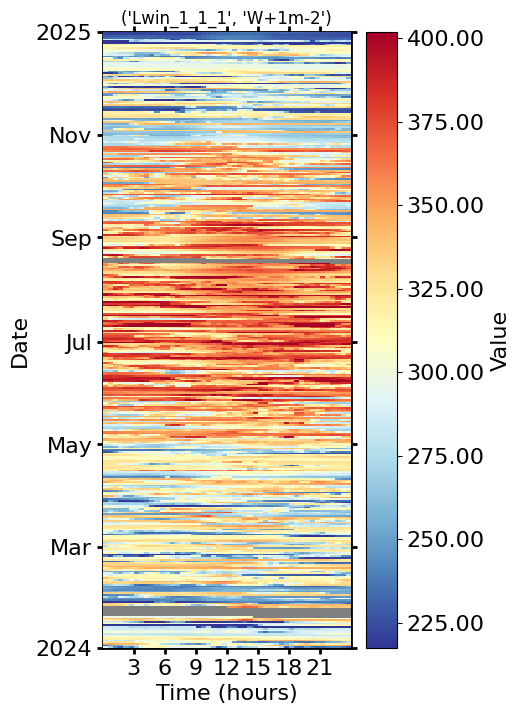

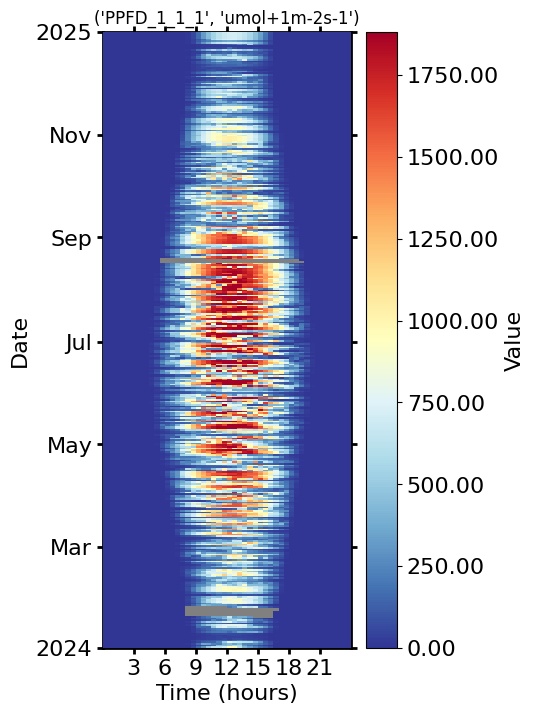

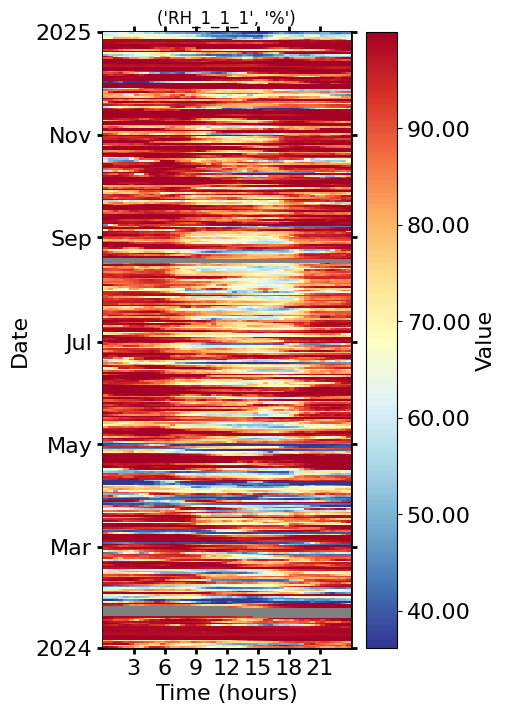

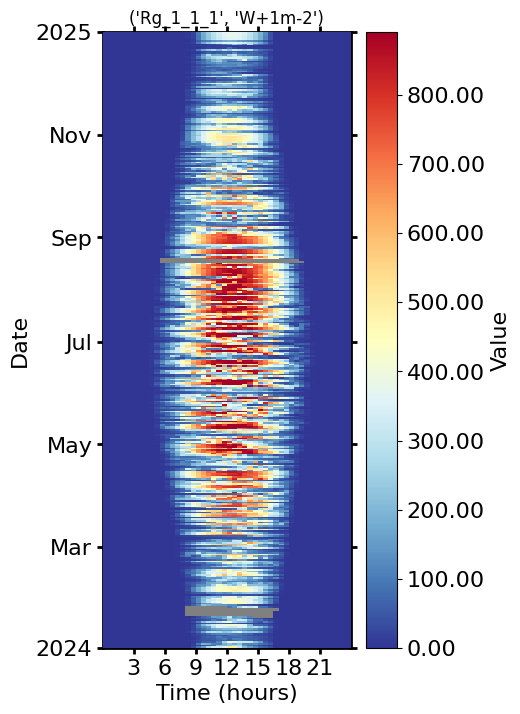

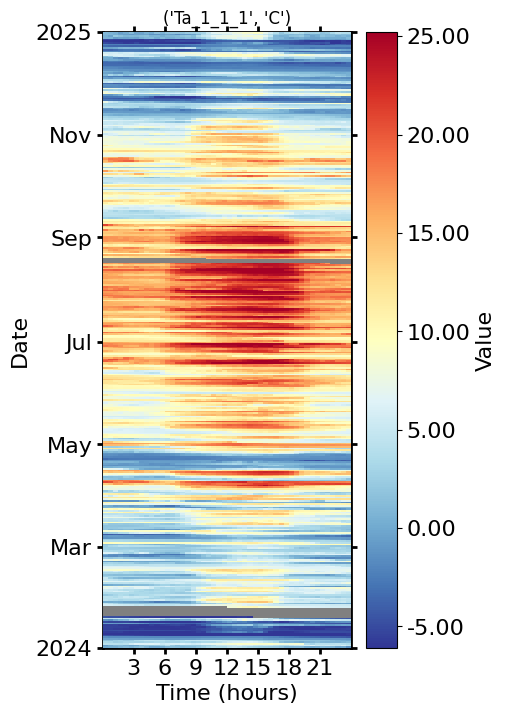

In [10]:
plotcols = [plotcol for plotcol in res.columns if not "TIMESTAMP" in plotcol[0]]
plotdf = res[plotcols].copy()

for col in plotdf.columns:
    series = plotdf[col].copy()
    series.replace(to_replace=-9999, value=np.nan, inplace=True)
    try:
        fig = plt.figure(facecolor='white', figsize=(4, 8))
        gs = gridspec.GridSpec(1, 1)  # rows, cols
        ax = fig.add_subplot(gs[0, 0])
        vmin = series.quantile(.01)
        vmax = series.quantile(.99)
        HeatmapDateTime(ax=ax, series=series, vmin=vmin, vmax=vmax).plot()
        ax.set_title(col, color='black')
        fig.show()
    except TypeError:
        pass

</br>

</br>

# **Save to CSV**

In [11]:
res.to_csv("meteo.csv", index=False)

</br>

# **End of notebook**

In [12]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished {dt_string}")

Finished 2025-02-24 18:24:42
